In [1]:
# Imports
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ODE Parameter Fitting Notebook

We're fitting parameters to the ODE: dy/dt = scale * sigmoid(mid) - degradation * y
where sigmoid(mid) = 1/(1 + exp(-mid))

This notebook will:
1. Define the model functions
2. Generate synthetic data
3. Fit parameters
4. Visualize results

In [2]:
# Model Definition
def sigmoid(mid):
    """Sigmoid function with fixed mid parameter"""
    return 1 / (1 + np.exp(-mid))

def ode_system(y, t, scale, mid, degradation):
    """ODE: dy/dt = scale * sigmoid(mid) - degradation * y"""
    dydt = scale * sigmoid(mid) - degradation * y
    return dydt

# Augmented system: state + sensitivities
def augmented_system(state, t, scale, mid, degradation):
    y, s_scale, s_mid, s_degrad = state  # state + sensitivities w.r.t. parameters
    
    sig = sigmoid(mid)
    dsig_dmid = sig * (1 - sig)  # derivative of sigmoid w.r.t. mid
    
    dydt = scale * sig - degradation * y
    ds_scale_dt = sig - degradation * s_scale  # d(dy/dt)/d(scale)
    ds_mid_dt = scale * dsig_dmid - degradation * s_mid  # d(dy/dt)/d(mid)
    ds_degrad_dt = -y - degradation * s_degrad  # d(dy/dt)/d(degradation)
    
    return [dydt, ds_scale_dt, ds_mid_dt, ds_degrad_dt]

## Data Generation

Let's create some synthetic data to test our fitting procedure. We'll add noise to simulate real measurements.

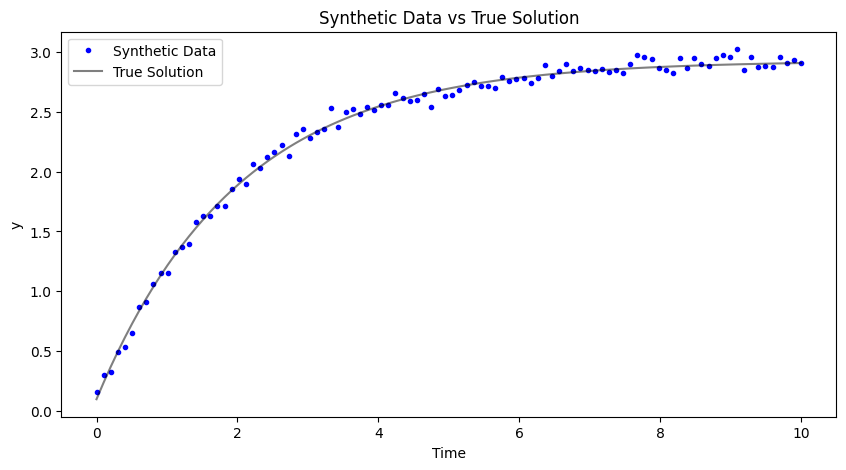

In [3]:
# Data Generation
def generate_data(true_params, t):
    """Generate synthetic data with noise"""
    y0 = 0.1  # Initial condition
    solution = odeint(ode_system, y0, t, args=(true_params['scale'], 
                                               true_params['mid'], 
                                               true_params['degradation']))
    noise = np.random.normal(0, 0.05, size=solution.shape)
    return solution + noise

# Time points and true parameters
t = np.linspace(0, 10, 100)
true_params = {'scale': 2.0, 'mid': 1.0, 'degradation': 0.5}

# Generate data
y_data = generate_data(true_params, t)

# Plot generated data
plt.figure(figsize=(10, 5))
plt.plot(t, y_data, 'b.', label='Synthetic Data')
plt.plot(t, odeint(ode_system, 0.1, t, args=(true_params['scale'], 
                                             true_params['mid'], 
                                             true_params['degradation'])), 
         'k-', alpha=0.5, label='True Solution')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('Synthetic Data vs True Solution')
plt.legend()
plt.show()

## Parameter Fitting

Now we'll define the optimization functions and fit the parameters to our data.

In [4]:
def compute_adjoint_gradient(params, t, y_data):
    """
    Compute gradient of J = sum((y - y_data)^2) w.r.t. parameters using adjoint method.
    
    Parameters:
    - params: array-like [scale, mid, degradation]
    - t: array of time points (increasing order)
    - y_data: array of observed data, same length as t
    
    Returns:
    - gradient: array [dJ/dscale, dJ/dmid, dJ/ddegradation]
    """
    scale, mid, degradation = params
    y0 = float(y_data[0])  # Initial condition from data
    y_data = np.asarray(y_data).flatten()  # Ensure 1D array
    
    # Step 1: Solve the forward ODE
    y = odeint(ode_system, y0, t, args=(scale, mid, degradation)).flatten()
    
    # Step 2: Define and solve the adjoint system backward
    def adjoint_system(lambda_, t_backward, scale, mid, degradation, t_forward, y, y_data):
        """Adjoint ODE: dλ/dt = degradation * λ - 2 * (y - y_data)"""
        # Convert backward time to forward time
        t_forward_current = t_forward[-1] - t_backward
        # Interpolate y and y_data at the current time
        idx = np.searchsorted(t_forward, t_forward_current)
        if idx >= len(t_forward):
            idx = len(t_forward) - 1
        y_t = y[idx]
        y_data_t = y_data[idx]
        dlambda_dt = degradation * lambda_ - 2 * (y_t - y_data_t)
        return -dlambda_dt  # Negative for backward integration
    
    # Initial condition for adjoint at t_final (λ(T) = 0)
    lambda0 = 0.0
    # Reverse time for backward integration
    t_backward = t[::-1]
    lambda_ = odeint(adjoint_system, lambda0, t_backward, 
                    args=(scale, mid, degradation, t, y, y_data)).flatten()[::-1]  # Reverse back to forward order
    
    # Step 3: Compute gradients by integrating adjoint with partial derivatives
    sig = sigmoid(mid)
    dsig_dmid = sig * (1 - sig)
    
    dJ_dscale = np.trapezoid(lambda_ * sig, t)
    dJ_dmid = np.trapezoid(lambda_ * scale * dsig_dmid, t)
    dJ_ddegrad = np.trapezoid(-lambda_ * y, t)
    
    return np.array([dJ_dscale, dJ_dmid, dJ_ddegrad])

# Gradient Descent
def gradient_descent(params_init, t, y_data, learning_rate=0.01, max_iter=1000, tol=1e-6):
    """
    Perform gradient descent to minimize J = sum((y - y_data)^2) using adjoint gradients.
    
    Parameters:
    - params_init: array-like [scale, mid, degradation], initial parameters
    - t: array of time points (increasing order)
    - y_data: array of observed data, same length as t
    - learning_rate: step size for parameter updates (default 0.01)
    - max_iter: maximum number of iterations (default 1000)
    - tol: tolerance for convergence (default 1e-6)
    
    Returns:
    - params: optimized parameters [scale, mid, degradation]
    - history: list of [params, J] at each iteration for tracking
    """
    params = np.array(params_init, dtype=float)  # Ensure NumPy array
    y0 = float(y_data[0])
    y_data = np.asarray(y_data).flatten()
    history = []
    
    for i in range(max_iter):
        # Compute forward solution and objective
        y = odeint(ode_system, y0, t, args=(params[0], params[1], params[2])).flatten()
        J = np.sum((y - y_data) ** 2)
        
        # Store current state
        history.append([params.copy(), J])
        
        # Compute gradient
        gradient = compute_adjoint_gradient(params, t, y_data)
        
        # Update parameters
        new_params = params - learning_rate * gradient
        
        # Check convergence (relative change in J)
        if i > 0:
            J_prev = history[-2][1]
            if abs(J - J_prev) / (J_prev + 1e-10) < tol:  # Avoid division by zero
                print(f"Converged after {i+1} iterations")
                break
        
        params = new_params
    
    else:
        print(f"Maximum iterations ({max_iter}) reached without convergence")
    
    return params, history

# Example usage (assuming t, y_data from previous notebook cells)
params = [1.0, 0.0, 1.0]  # Initial guess [scale, mid, degradation]
gradient = compute_adjoint_gradient(params, t, y_data)
print(f"Gradient at {params}:")
print(f"dJ/dscale = {gradient[0]:.3f}")
print(f"dJ/dmid = {gradient[1]:.3f}")
print(f"dJ/ddegradation = {gradient[2]:.3f}")

Gradient at [1.0, 0.0, 1.0]:
dJ/dscale = 16300.902
dJ/dmid = 8150.451
dJ/ddegradation = -10802.763


C:\Users\Admin\AppData\Local\Temp\ipykernel_42208\3209281097.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y0 = float(y_data[0])  # Initial condition from data


In [5]:
# Example usage
params_init = np.array([1.0, 0.0, 1.0])  # Initial guess [scale, mid, degradation]
t = np.linspace(0, 10, 100)  # Assuming from previous context
y_data = np.random.normal(0, 1, 100)  # Dummy data; replace with your y_data
params_opt, history = gradient_descent(params_init, t, y_data, learning_rate=0.01)

print(f"Initial parameters: {params_init}")
print(f"Optimized parameters: {params_opt}")
print(f"Final objective value: {history[-1][1]:.3f}")

Converged after 3 iterations
Initial parameters: [1. 0. 1.]
Optimized parameters: [ 5.28454300e+105  2.35201099e+099 -1.50927999e+108]
Final objective value: 14987957295969033358610449436080917136401805371856813629004174950736722602642552315798024770836133465438608185769861710309818534788422493539259275067845710240666135926947112196488000045129244671643430597870737412556062720.000


C:\Users\Admin\AppData\Local\Temp\ipykernel_42208\3209281097.py:75: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  y = odeint(ode_system, y0, t, args=(params[0], params[1], params[2])).flatten()
C:\Users\Admin\AppData\Local\Temp\ipykernel_42208\3209281097.py:18: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  y = odeint(ode_system, y0, t, args=(scale, mid, degradation)).flatten()
C:\Users\Admin\AppData\Local\Temp\ipykernel_42208\3209281097.py:38: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  lambda_ = odeint(adjoint_system, lambda0, t_backward,


In [6]:
params_init = np.array([1.0, 0.0, 1.0])
params_opt, history = gradient_descent(params_init, t, y_data, learning_rate=0.0001)
print(f"Optimized params: {params_opt}")
print(f"Final J: {history[-1][1]}")

Converged after 15 iterations
Optimized params: [ 8.60655992e+47  5.89618422e+47 -4.80231592e+49]
Final J: 1.175799927848478e+108


C:\Users\Admin\AppData\Local\Temp\ipykernel_42208\3209281097.py:75: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  y = odeint(ode_system, y0, t, args=(params[0], params[1], params[2])).flatten()
C:\Users\Admin\AppData\Local\Temp\ipykernel_42208\3209281097.py:18: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  y = odeint(ode_system, y0, t, args=(scale, mid, degradation)).flatten()
C:\Users\Admin\AppData\Local\Temp\ipykernel_42208\3209281097.py:38: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  lambda_ = odeint(adjoint_system, lambda0, t_backward,


## Results Visualization

Let's compare the fitted model with the data and true solution.

In [7]:
# Results Visualization
y_fit = odeint(ode_system, y_data[0], t, args=(scale_fit, mid_fit, degradation_fit))
y_true = odeint(ode_system, 0.1, t, args=(true_params['scale'], 
                                        true_params['mid'], 
                                        true_params['degradation']))

plt.figure(figsize=(12, 6))
plt.plot(t, y_data, 'b.', label='Data', alpha=0.5)
plt.plot(t, y_fit, 'r-', label='Fitted Model')
plt.plot(t, y_true, 'k--', label='True Solution', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('y')
plt.title('ODE Fitting Results')
plt.legend()
plt.grid(True)
plt.show()

# Residual plot
residuals = y_fit.flatten() - y_data
plt.figure(figsize=(12, 4))
plt.plot(t, residuals, 'g.', label='Residuals')
plt.axhline(0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Residual (Fit - Data)')
plt.title('Residuals of Fit')
plt.grid(True)
plt.show()

NameError: name 'scale_fit' is not defined

## Interactive Exploration

Try changing the true parameters or noise level and re-run the cells to see how it affects the fitting!